In [ ]:
Let's now consider the 

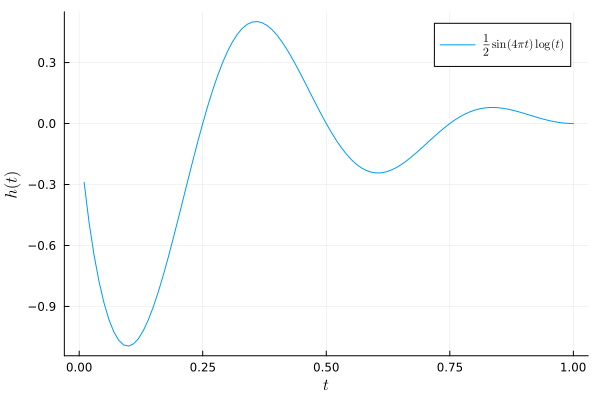

In [1]:
using Plots, Flux, LinearAlgebra, LaTeXStrings
using Statistics: mean
using Flux: @functor, params, gradient


h(x) = 1/2 * sin(4 * pi * x) * log(x)

T = [0.0, 1.0]

t = collect(T[1]:0.01:T[2])
h_t = h.(t)
plt = plot(t, h, xlabel=L"$t$", ylabel=L"$h(t)$", label=L"$\frac{1}{2}\sin(4\pi t)\log(t)$", fmt=:png)

In [2]:
function rk4(ht, t, d, f)
    k1 = f(ht, t)
    k2 = f(ht+d*k1/2, t+d/2)
    k3 = f(ht+d*k2/2, t+d/2)
    k4 = f(ht+d*k3, t+d)
    return ht + d/6*(k1 + 2*k2 + 2*k3 + k4)
end

function euler(ht, t, d, f)
    return ht + d*f(ht, t)
end

function sample(lower, upper, d)
    t1 = rand() * (upper - lower) + lower
    t2 = t1 + d
    ht1, ht2 = h(t1), h(t2)
    return ht1, t1, ht2, t2
end

function sample_batch(lower, upper, d, num_samples)
    lower, upper, d = map(x -> repeat([x], num_samples), (lower, upper, d))

    sample_broadcast(l, u, disc) = vcat(sample(l, u, disc)...)

    out = sample_broadcast.(lower, upper, d)
    out = transpose(hcat(out...))
    return out[:,1], out[:,2], out[:,3], out[:,4]
end

struct CustomModel
    neuralnet
end

CustomModel() = CustomModel(
    Chain(
        Dense(2 => 32, tanh),
        [Dense(32 => 32, tanh) for _ in 1:5]...,
        Dense(32 => 1)
    )
)

function (m::CustomModel)(args::Float64...)
    out = m.neuralnet(vcat(args...))
    return out[1]
end
@functor CustomModel

f_hat = CustomModel()

CustomModel(Chain(Dense(2 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 1)))

In [3]:
optim = Flux.setup(Flux.Adam(0.001), f_hat)
d = 0.01

losses = []
for i in 1:3000
    ht1, t1, ht2, t2 = sample_batch(T..., d, 256)
    loss(model) = mean((euler.(ht1, t1, d, Ref(model)) .- ht2).^2)
    loss, grads = Flux.withgradient(f_hat) do m
        loss(m)
    end
    Flux.update!(optim, f_hat, grads[1])
    push!(losses, loss)
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, tanh)
│   summary(x) = 2-element Vector{Float64}
└ @ Flux /Users/lionelpeer/.julia/packages/Flux/CUn7U/src/layers/stateless.jl:60


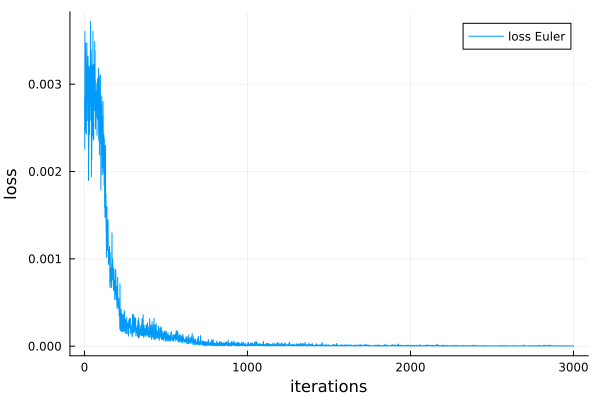

In [4]:
plt = plot(losses, xlabel="iterations", ylabel="loss", label="loss Euler", fmt=:png)

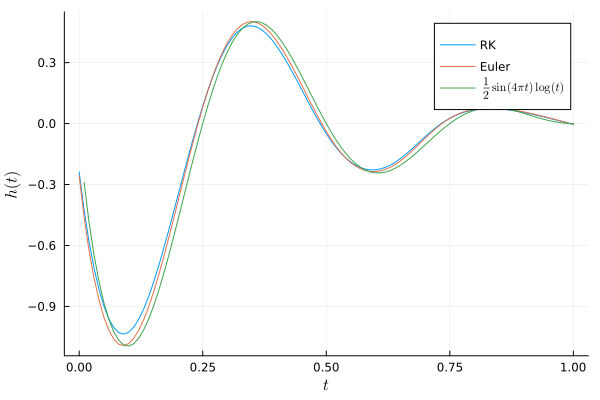

In [5]:
ht_rk = 0.0
ht_euler = 0.0
trace_rk = []
trace_euler = []
for t in T[1]:d:T[2]
    ht_rk = rk4(ht_rk, t, d, f_hat)
    push!(trace_rk, ht_rk)

    ht_euler = euler(ht_euler, t, d, f_hat)
    push!(trace_euler, ht_euler)
end

plot(collect(T[1]:d:T[2]), trace_rk, label="RK")
plot!(collect(T[1]:d:T[2]), trace_euler, label="Euler")
plt = plot!(t, h, xlabel=L"$t$", ylabel=L"$h(t)$", label=L"$\frac{1}{2}\sin(4\pi t)\log(t)$", fmt=:png)